ggtree v3.16.0 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

S Xu, Z Dai, P Guo, X Fu, S Liu, L Zhou, W Tang, T Feng, M Chen, L
Zhan, T Wu, E Hu, Y Jiang, X Bo, G Yu. ggtreeExtra: Compact
visualization of richly annotated phylogenetic data. Molecular Biology
and Evolution. 2021, 38(9):4039-4042. doi: 10.1093/molbev/msab166


Attaching package: ‘ggtree’


The following object is masked from ‘package:ape’:

    rotate



Attaching package: ‘dplyr’


The following object is masked from ‘package:ape’:

    where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:ggtree’:

    expand


Rows: 3084 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): tube_code
dbl (4): PATIENT_ID, death_7_day, death_14_day, d

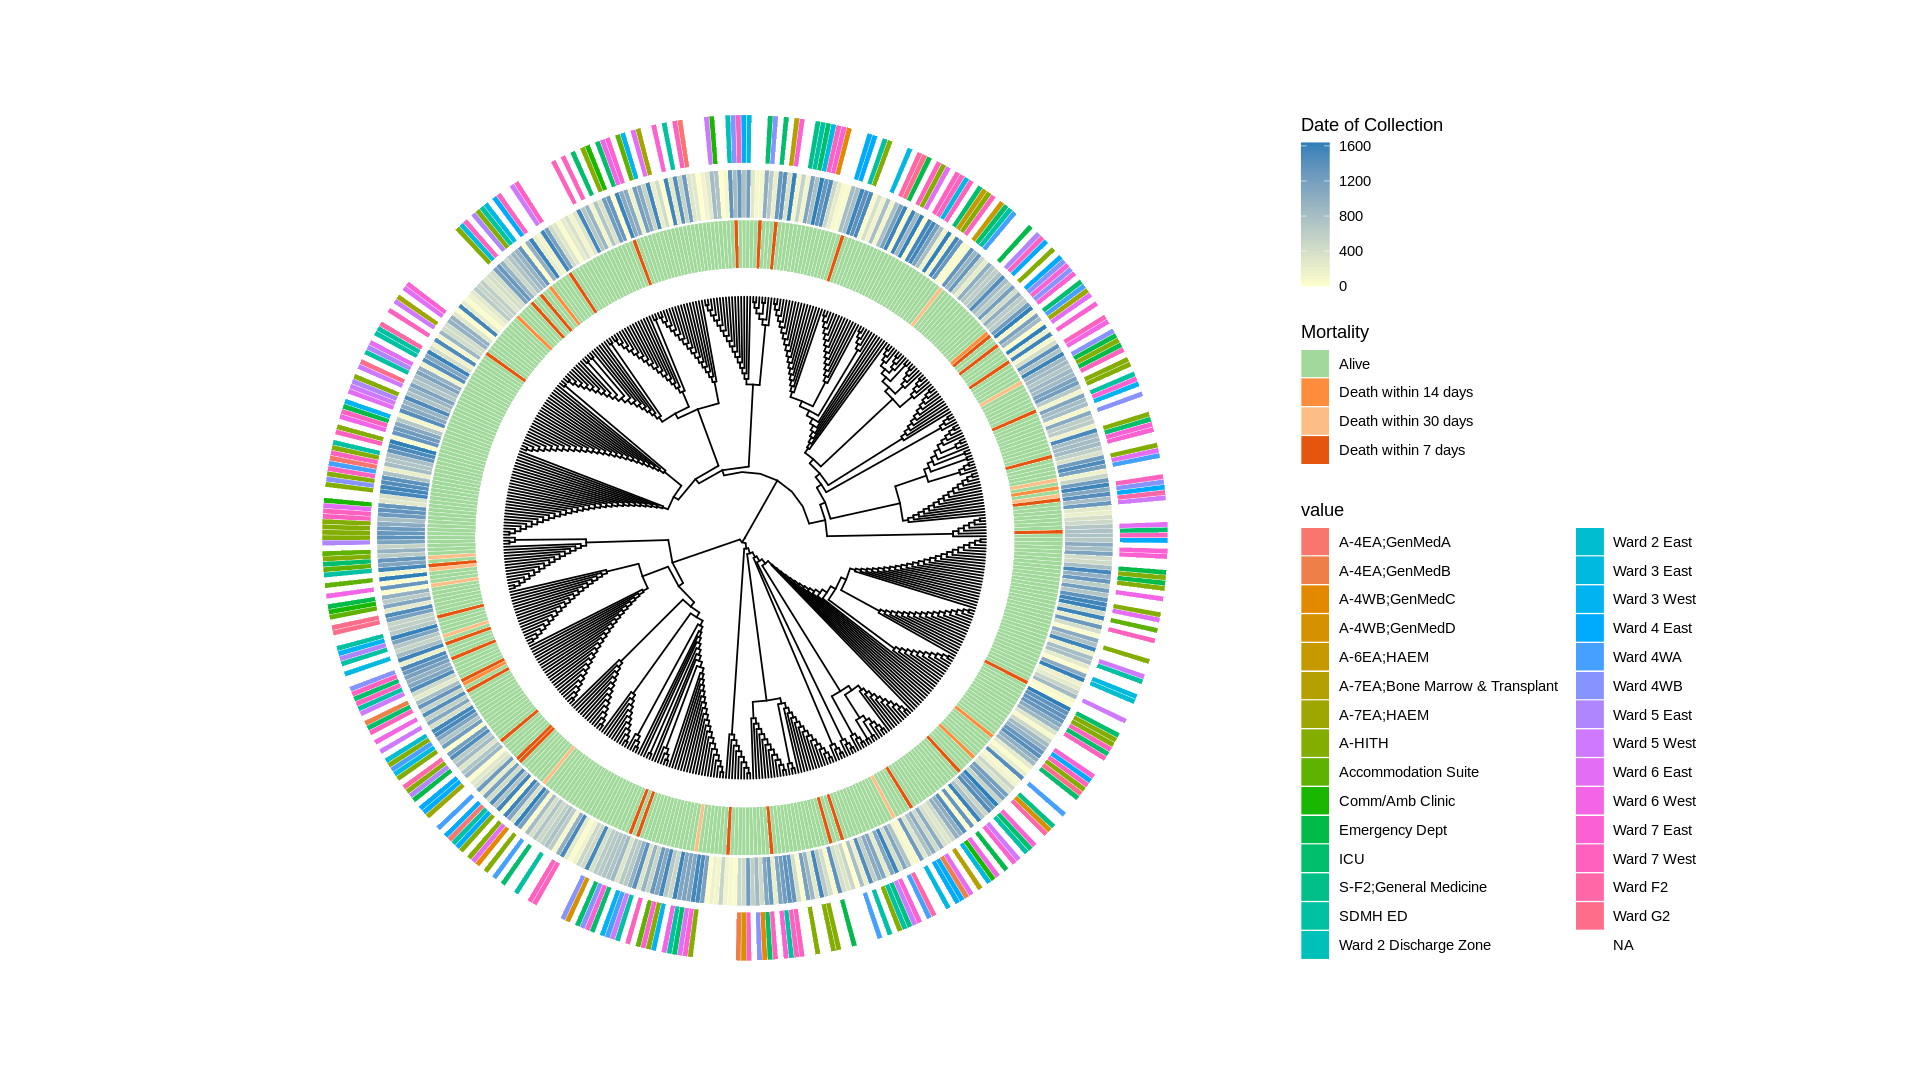

In [1]:
options(repr.plot.width = 16, repr.plot.height = 9)

library(ape)
library(ggtree)
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(ggnewscale)


tree <- read.tree(
  "~/workspace/genome_data/annotations/s_aureus/gene_sequences/essC_tree.nwk"
)

mortality_df <- read_csv(
  "~/workspace/ehr_data/data/full_cohort/tube_id_mortality_labels.csv"
)

collection_date_df <- read_csv(
  "~/workspace/ehr_data/data/full_cohort/tube_id_collection_date.csv"
)

location_df <- read_csv(
  "~/workspace/ehr_data/data/full_cohort/tube_id_location.csv"
)

df <- data.frame(tube_code = tree$tip.label)

circ <- ggtree(tree, layout = "circular", branch.length = "none")

mortality_df <- mortality_df %>%
  mutate(
    death_category = ifelse(
      (death_7_day == "1"),
      "Death within 7 days",
      ifelse(
        (death_14_day == "1"),
        "Death within 14 days",
        ifelse(
          (death_30_day == "1"),
          "Death within 30 days",
          "Alive"
        )
      )
    )
  ) %>%
  select(-death_7_day, -death_14_day, -death_30_day)

heatmap_data <- df %>%
  left_join(mortality_df, by = "tube_code")

rownames(heatmap_data) <- heatmap_data$tube_code
heatmap_data <- heatmap_data[
  , c("death_category"), drop = FALSE
]

heatmap_data <- heatmap_data %>%
  mutate(death_category = replace_na(death_category, "Alive"))

heatmap_data$death_category <- factor(
  heatmap_data$death_category,
  levels = c(
    "Alive",
    "Death within 30 days",
    "Death within 14 days",
    "Death within 7 days"
  )
)

collection_date_heatmap_data <- df %>%
  left_join(collection_date_df, by = "tube_code")

rownames(collection_date_heatmap_data) <- collection_date_heatmap_data$tube_code

location_heatmap_data <- df %>%
  left_join(location_df, by = "tube_code")

rownames(location_heatmap_data) <- location_heatmap_data$tube_code

p <- gheatmap(
  circ,
  heatmap_data,
  offset = .8,
  width = .2,
  colnames = FALSE,
) +
  scale_fill_manual(
    values = c(
      "Alive" = "#A1D99B",
      "Death within 30 days" = "#FDBE85",
      "Death within 14 days" = "#FD8D3C",
      "Death within 7 days" = "#E6550D"
    ),
    name = "Mortality"
  ) +
  new_scale_fill()

p <- gheatmap(
  p,
  collection_date_heatmap_data %>% select(date_of_collection),
  offset = 10,
  width = .2,
  colnames = FALSE
) +
  scale_fill_gradient(
    name = "Date of Collection",
    low = "#ffffcc",
    high = "#2c7fb8"
  ) +
  new_scale_fill()

p <- gheatmap(
  p,
  location_heatmap_data %>% select(location),
  offset = 20,
  width = .2,
  colnames = FALSE
)

p